# Setup

In [80]:
import torch
from torchvision.datasets import EMNIST
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.transforms.functional as transforms_F
import os
import torch
import torchvision.transforms as transforms
import torchvision.transforms.functional as transforms_F
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader, Subset
import random

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
# Hyper-parameters
num_epochs = 5
input_size = 784 # 28x28
hidden_size = 1000
batch_size = 128
learning_rate = 0.005

# Loading Data

In [83]:
# def binarize(img, threshold=0.5):
#     return (img > threshold).float()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [84]:
# load full emnist datasets
train_dataset = EMNIST(root="./data", split="byclass", train=True, download=True, transform=transform)
test_dataset = EMNIST(root="./data", split="byclass", train=False, download=True, transform=transform)

# select random subsets of the data to work with

train_size = len(train_dataset) // 4
train_indices = random.sample(range(len(train_dataset)), train_size)
train_subset = Subset(train_dataset, train_indices)

test_size = len(test_dataset) // 4
test_indices = random.sample(range(len(test_dataset)), test_size)
test_subset = Subset(test_dataset, test_indices)

In [85]:
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

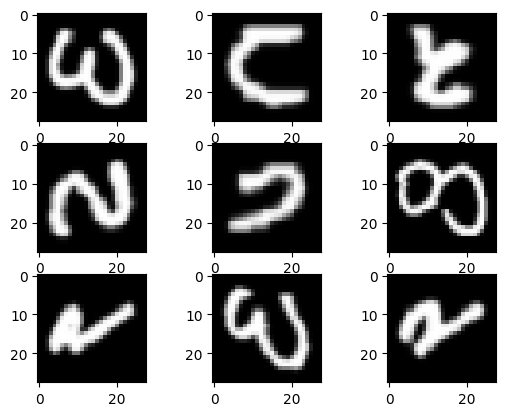

In [86]:
examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

# Defining the model
Went for a simple network with 2 convolution steps.

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 62)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Initializing the model, loss criteria, and optimizer.

In [88]:
model = Conv().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model

In [89]:
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Running lose [{running_loss / len(train_loader):.4f}]')

Epoch [1/5], Running lose [0.7575]
Epoch [2/5], Running lose [0.5388]
Epoch [3/5], Running lose [0.5055]
Epoch [4/5], Running lose [0.4878]
Epoch [5/5], Running lose [0.4771]


# Evaluating on test set

In [90]:
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {acc} %')

Accuracy of the network on the 29080 test images: 82.64786795048143 %


# Saving and exporting the model

In [91]:
model_path = "emnist_cnn_classifier.pth"
torch.save(model.state_dict(), model_path)

In [92]:
from google.colab import files

files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>